# Results Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
results_dir = "results"

In [3]:
selected_graphs = ["16-6.txt", "18-5.txt", "25-4.txt", "20-5.txt"]
n_threads_parallel = [1, 2, 4, 6, 8, 12, 16, 20]
n_threads_distrib = [6, 8, 12, 16, 20]

In [4]:
def get_data(path, selected_graphs):
    df = pd.read_csv(path)
    df = df.loc[df['filename'].isin(selected_graphs)]
    return df

In [5]:
def add_unfinished(df, selected_graphs, n_threads):
    for graph in selected_graphs:
        graph_df = df.loc[df['filename'] == graph]
        
        # add empty rows for tests that did not complete
        empty_row = graph_df.iloc[0].copy()
        
        for n_thread in n_threads:
            if n_thread not in graph_df["n threads"].tolist():
                empty_row["n threads"] = n_thread
                empty_row["time[s]"] = float("inf")
                df=df.append(empty_row, ignore_index=True)
                
    return df

In [6]:
def create_twins(axes):
    twins = []
    
    for ax in axes:
        twins.append(ax.twinx())
        
    assert len(twins) == len(twins)
    return twins

In [7]:
def plot_bar(ax, df, label_col, data_col, x_label, y_label, title):
    bar = sns.barplot(x=label_col, y=data_col, data=df, ax=ax)
    bar.set(xlabel=x_label, ylabel=y_label)
    ax.set_title(title)
    
    # add top bar labels
    duration = ["{:.0f}".format(dur) for dur in list(df[data_col])]
    _ = ax.bar_label(bar.containers[0], duration)

In [8]:
def plot_bars(axes, df, selected_graphs):
    for ax, graph in zip(axes, selected_graphs):
        graph_df = df.loc[df['filename'] == graph]
        graph_df = graph_df.sort_values(by=["n threads"])
            
        plot_bar(ax, graph_df, "n threads", "time[s]", "Počet vláken", "Doba výpočtu[s]", graph)

In [9]:
def plot_efficiency(axes, df, selected_graphs):
    for ax, graph in zip(axes, selected_graphs):
        graph_df = df.loc[df['filename'] == graph]
        graph_df = graph_df.sort_values(by=["n threads"])
        
        durations = list(graph_df['time[s]'])
        n_threads = list(graph_df["n threads"])
        efficiencies = np.zeros(len(durations))
        
        for idx in range(1, len(durations)):
            assert idx > 0
            assert idx < len(durations)
            efficiencies[idx] = efficiency(durations[idx], durations[idx-1])
        
        efficiencies[0] = np.nan
        
        ax.plot(efficiencies, color="black", marker='o')
        ax.set_ylim(bottom=0)
        ax.set_ylabel("Zrychlení[%]")

## Sequential

In [10]:
seq_filename = "seq-res.csv"
path = os.path.join(results_dir, seq_filename)

seq_df = get_data(path, selected_graphs)
display(seq_df)

,filename,n vertices,n edges,time[s]
0,16-6.txt,16,48,406.913
1,18-5.txt,18,45,286.398
3,25-4.txt,25,50,283.381
4,20-5.txt,20,50,273.753


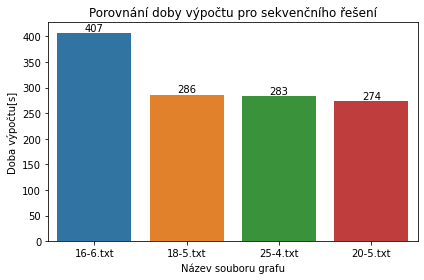

In [11]:
fig, ax = plt.subplots()
plot_bar(ax, seq_df, "filename", "time[s]", "Název souboru grafu", "Doba výpočtu[s]",
         "Porovnání doby výpočtu pro sekvenčního řešení")
fig.tight_layout()
plt.savefig("report/report/images/seq-graph.png", dpi=400)

## Task Parallelism

In [12]:
path = os.path.join(results_dir, "parallel-task-res.csv")
task_df = get_data(path, selected_graphs)
task_df = add_unfinished(task_df, selected_graphs, n_threads_parallel)
display(task_df.head())

,filename,n vertices,n edges,sequential ratio,n threads,time[s]
0,16-6.txt,16,48,0.5,1,500.514
1,16-6.txt,16,48,0.5,4,358.296
2,16-6.txt,16,48,0.5,6,254.566
3,16-6.txt,16,48,0.5,8,213.560
4,16-6.txt,16,48,0.5,12,179.121


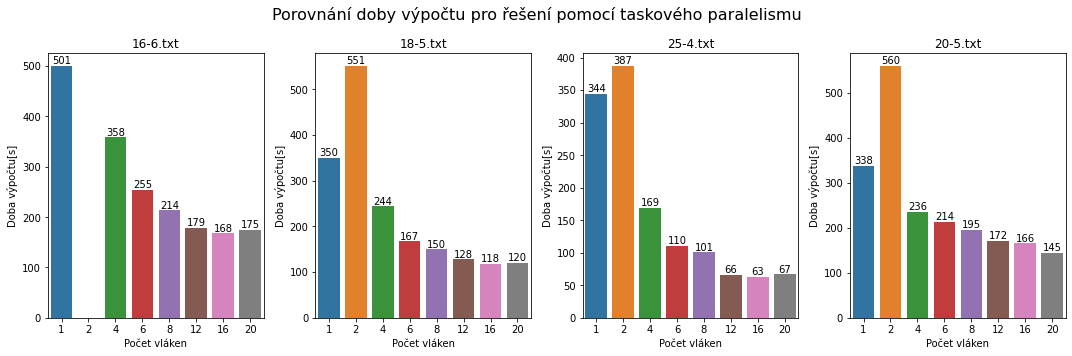

In [13]:
fig, axes = plt.subplots(1, len(selected_graphs), figsize=(15, 5))

plot_bars(axes, task_df, selected_graphs)
    
fig.suptitle("Porovnání doby výpočtu pro řešení pomocí taskového paralelismu", fontsize=16)    
fig.tight_layout()
plt.savefig("report/report/images/parallel-task-graph.png", dpi=400)

## Data Parallelism

In [14]:
data_path = os.path.join(results_dir, "parallel-data-res.csv")
data_df = get_data(data_path, selected_graphs)
data_df = add_unfinished(data_df, selected_graphs, n_threads_parallel)
display(data_df.head())

,filename,n vertices,n edges,max depth,n threads,time[s]
0,16-6.txt,16,48,5,1,218.256
1,16-6.txt,16,48,5,2,319.579
2,16-6.txt,16,48,5,4,274.970
3,16-6.txt,16,48,5,6,213.489
4,16-6.txt,16,48,5,8,187.537


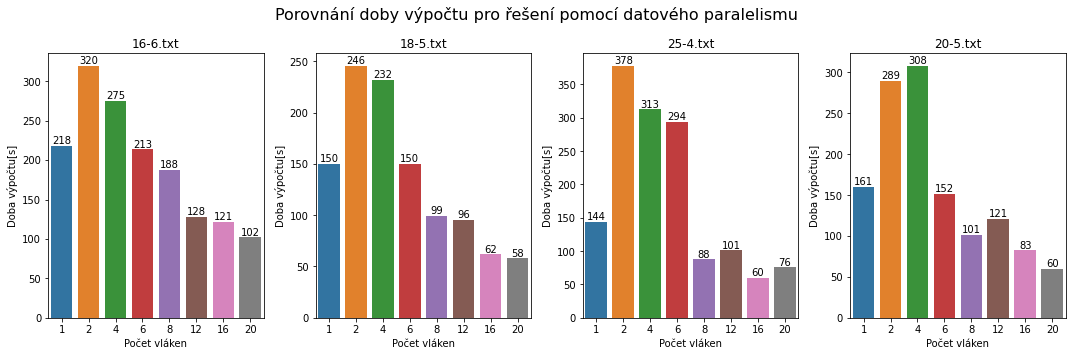

In [15]:
fig, axes = plt.subplots(1, len(selected_graphs), figsize=(15, 5))

plot_bars(axes, data_df, selected_graphs)

fig.suptitle("Porovnání doby výpočtu pro řešení pomocí datového paralelismu", fontsize=16)    
fig.tight_layout()
plt.savefig("report/report/images/parallel-data-graph.png", dpi=400)

## Distributed

In [16]:
distrib_path = os.path.join(results_dir, "distributed-res.csv")
distrib_df = get_data(distrib_path, selected_graphs)
distrib_df = add_unfinished(distrib_df, selected_graphs, n_threads_distrib)
display(distrib_df.head())

,filename,n vertices,n edges,max depth master,max depth slave,n processes,n threads,time[s]
0,16-6.txt,16,48,5,6,4,6,64.4211
1,16-6.txt,16,48,5,6,4,8,55.7499
2,16-6.txt,16,48,5,6,4,12,43.4439
3,16-6.txt,16,48,5,6,4,16,37.3608
4,16-6.txt,16,48,5,6,4,20,32.9847


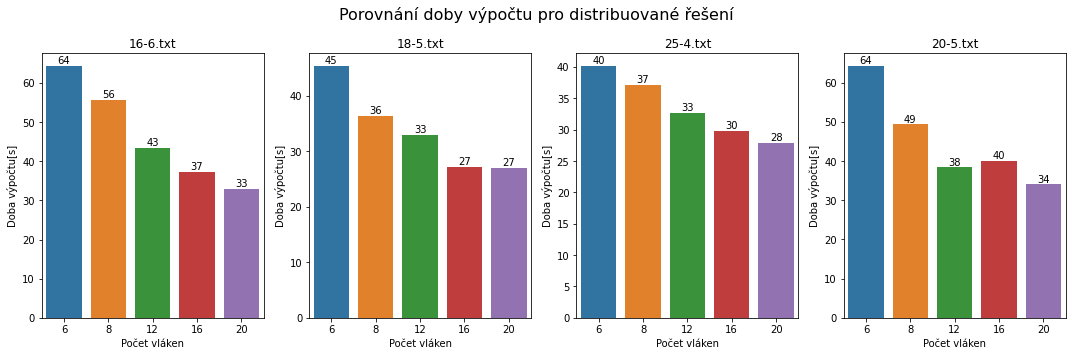

In [17]:
fig, axes = plt.subplots(1, len(selected_graphs), figsize=(15, 5))

plot_bars(axes, distrib_df, selected_graphs)

fig.suptitle("Porovnání doby výpočtu pro distribuované řešení", fontsize=16)    
fig.tight_layout()
plt.savefig("report/report/images/distrib-graph.png", dpi=400)